In [386]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statsmodels.api as sm
import statsmodels.formula.api as smf
plt.style.use('seaborn-whitegrid')

In [387]:
# magic to reload modules automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [388]:
#conda install -c conda-forge statsmodels

In [389]:
rt = pd.read_excel('rt.xlsx')
it = pd.read_excel('it.xlsx')
ff = pd.read_excel('ff.xlsx')
print(rt.shape)
print(it.shape)
print(ff.shape)

(2348, 115)
(2349, 125)
(2324, 8)


In [390]:
pd.set_option('display.max_columns',125) # I want to see all the columns
pd.set_option('display.max_rows',600) 

In [391]:
it = it.loc[:,['Unnamed: 0.1','DAX Index','OMXS30B Index','OMXC25 Index','OMX Index']]

In [392]:
for i in it.columns[1:]:
    it.loc[:,i] = it.loc[:,i].pct_change(1)*100
it.drop(index=[0], inplace=True)

In [393]:
it.rename(columns={'Unnamed: 0.1' : 'date'}, inplace=True)
rt.drop(columns='Unnamed: 0', inplace=True)
ff.drop(columns='Unnamed: 0', inplace=True)
rt = rt.loc[:,['date','port_low','port_mid','port_high']]

In [394]:
rt = rt.merge(ff,on=['date'], how='left')
rt = rt.merge(it,on=['date'], how='left')

In [395]:
pd.set_option("display.precision", 5)
rt['RF'] = rt['RF']*100

In [396]:
rt.rename(columns={'Mkt-RF' : 'MktRF'}, inplace=True)

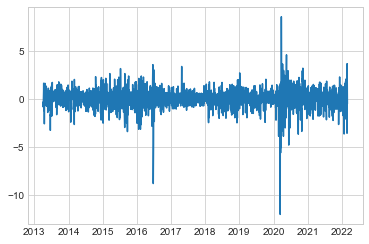

In [397]:
plt.plot(rt['date'], rt['MktRF']);

In [398]:
filt = (rt['date'] >= pd.to_datetime('2013-01-01')) & (rt['date'] <= pd.to_datetime('2022-02-28')) 
rt = rt[filt]
rt.dropna(how='all', axis='index', thresh=5, inplace=True)

In [399]:
rt.describe()

,port_low,port_mid,port_high,MktRF,SMB,HML,RMW,CMA,RF,DAX Index,OMXS30B Index,OMXC25 Index,OMX Index
count,2324.00000,2324.00000,2324.00000,2324.00000,2324.00000,2324.00000,2324.00000,2324.00000,2324.00000,2324.00000,2324.00000,2324.00000,2324.00000
mean,0.07354,0.04097,0.04706,0.02896,0.00933,-0.00662,0.01384,-0.00840,0.24269,0.03307,0.03050,0.05289,0.03050
std,1.02560,1.02809,1.06378,1.00478,0.41555,0.53081,0.29968,0.29304,0.42880,1.20481,1.10024,1.04172,1.10024
min,-10.38933,-10.68079,-11.41330,-12.01000,-3.32000,-3.03000,-1.74000,-1.74000,0.00000,-12.23862,-10.57105,-8.02912,-10.57117
25%,-0.38565,-0.43167,-0.42369,-0.43000,-0.22000,-0.28000,-0.15000,-0.18000,0.00000,-0.47308,-0.51934,-0.49635,-0.51907
50%,0.09856,0.04939,0.06716,0.06000,0.01000,-0.03000,0.02000,-0.01000,0.00000,0.05404,0.02466,0.03232,0.02470
75%,0.58261,0.58351,0.55103,0.54000,0.25000,0.25000,0.18000,0.15000,0.00000,0.61673,0.62048,0.65593,0.62056
max,7.12380,6.81276,8.87625,8.54000,1.86000,4.38000,2.69000,1.31000,1.00000,10.97590,7.08908,5.07265,7.08859


In [400]:
rt.loc[:,['port_low','port_mid','port_high','MktRF']].corr()

,port_low,port_mid,port_high,MktRF
port_low,1.00000,0.89813,0.88040,0.79981
port_mid,0.89813,1.00000,0.92794,0.83673
port_high,0.88040,0.92794,1.00000,0.85539
MktRF,0.79981,0.83673,0.85539,1.00000


In [ ]:
res1 = sm.OLS(

                            OLS Regression Results                            
Dep. Variable:               port_low   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     4122.
Date:                Mon, 18 Apr 2022   Prob (F-statistic):               0.00
Time:                        13:50:37   Log-Likelihood:                -2169.7
No. Observations:                2324   AIC:                             4343.
Df Residuals:                    2322   BIC:                             4355.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0499      0.013      3.905      0.0

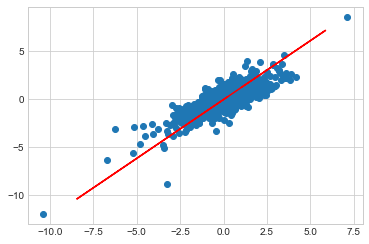

In [401]:
model1 = smf.ols(formula='port_low ~ MktRF', data=rt).fit() 
print(model1.summary())
trend = model1.params[0] + model1.params[1]* rt['port_low']
plt.scatter(rt['port_low'],rt['MktRF'])
plt.plot(trend, rt['port_low'], 'r');

                            OLS Regression Results                            
Dep. Variable:               port_mid   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     5421.
Date:                Mon, 18 Apr 2022   Prob (F-statistic):               0.00
Time:                        13:50:37   Log-Likelihood:                -1962.0
No. Observations:                2324   AIC:                             3928.
Df Residuals:                    2322   BIC:                             3940.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0162      0.012      1.384      0.1

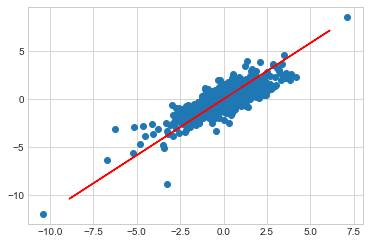

In [402]:
model2 = smf.ols(formula='port_mid ~ MktRF', data=rt).fit() 
print(model2.summary())
trend = model2.params[0] + model2.params[1]* rt['port_low']
plt.scatter(rt['port_low'],rt['MktRF'])
plt.plot(trend, rt['port_low'], 'r');

                            OLS Regression Results                            
Dep. Variable:              port_high   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     6332.
Date:                Mon, 18 Apr 2022   Prob (F-statistic):               0.00
Time:                        13:50:38   Log-Likelihood:                -1912.1
No. Observations:                2324   AIC:                             3828.
Df Residuals:                    2322   BIC:                             3840.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0208      0.011      1.821      0.0

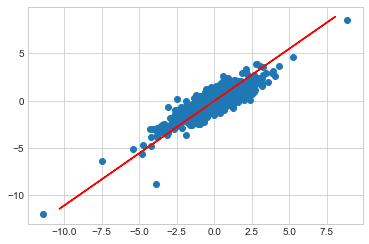

In [403]:
model3 = smf.ols(formula='port_high ~ MktRF', data=rt).fit() 
print(model3.summary())
trend = model3.params[0] + model3.params[1]* rt['port_high']
plt.scatter(rt['port_high'],rt['MktRF'])
plt.plot(trend, rt['port_high'], 'r');